# Mesure de la performance du modèle

L'objet de ce notebook est d'illustrer la méthodologie de mesure de la performance du modèle.


## Préambule technique

In [1]:
# setting up sys.path for relative imports
from pathlib import Path
import sys
project_root = str(Path(sys.path[0]).parents[1].absolute())
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
# imports and customization of diplay
import os
from functools import partial
import numpy as np
from scipy.stats import linregress
import pandas as pd
pd.options.display.min_rows = 6
pd.options.display.width=108
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from src.pimest import ContentGetter
from src.pimest import PathGetter
from src.pimest import PDFContentParser
from src.pimest import BlockSplitter
from src.pimest import SimilaritySelector
from src.pimest import custom_accuracy
from src.pimest import text_sim_score
from src.pimest import text_similarity
from src.pimest import build_text_processor

In [4]:
# monkeypatch _repr_latex_ for better inclusion of dataframes output in report
def _repr_latex_(self, size='scriptsize',):
    return(f"\\resizebox{{\\linewidth}}{{!}}{{\\begin{{{size}}}\\centering{{{self.to_latex()}}}\\end{{{size}}}}}")
pd.DataFrame._repr_latex_ = _repr_latex_

## Acquisition des données

On récupère les données manuellement étiquetées et on les intègre dans un dataframe

In [5]:
ground_truth_df = pd.read_csv(Path('..') / '..' / 'ground_truth' / 'manually_labelled_ground_truth.csv',
                              sep=';',
                              encoding='latin-1',
                              index_col='uid')
ground_truth_uids = list(ground_truth_df.index)

acqui_pipe = Pipeline([('PathGetter', PathGetter(ground_truth_uids=ground_truth_uids,
                                                  train_set_path=Path('..') / '..' / 'ground_truth',
                                                  ground_truth_path=Path('..') / '..' / 'ground_truth',
                                                  )),
                        ('ContentGetter', ContentGetter(missing_file='to_nan')),
                        ('ContentParser', PDFContentParser(none_content='to_empty')),
                       ],
                       verbose=True)

texts_df = acqui_pipe.fit_transform(ground_truth_df)
texts_df['ingredients'] = texts_df['ingredients'].fillna('')
texts_df.sample(4)

[Pipeline] ........ (step 1 of 3) Processing PathGetter, total=   0.1s
[Pipeline] ..... (step 2 of 3) Processing ContentGetter, total=   0.6s
Launching 8 processes.
[Pipeline] ..... (step 3 of 3) Processing ContentParser, total=  37.0s


,designation,ingredients,path,content,text
uid,,,,,
d5aeaf70-6b1e-4535-9d4e-dbef142da572,Café moulu Sélection 100% arabica Bio en paque...,Café*. *Ingrédient issu de l'agriculture biolo...,../../ground_truth/d5aeaf70-6b1e-4535-9d4e-dbe...,b'%PDF-1.5\r%\xe2\xe3\xcf\xd3\r\n13 0 obj\r<</...,www.destination-bio.com - contact@cdc-destinat...
be17352c-dfc6-4860-9ab3-19c38abd7c4b,Ravioli pur buf en boîte 1/2 MAINGOURD,"Eau, ravioli [pâte (semoule de blé dur, eau, g...",../../ground_truth/be17352c-dfc6-4860-9ab3-19c...,b'%PDF-1.7\n\x8e\x9d\xa3\xb4\xc5\xd6\xe7\xf8\n...,Service Qualité CGC\nDivision Plats Cuisinés\n...
c4afd49b-aac9-4071-a168-d0ba79ab93e6,Confiture extra de fraise en pot verre 30 g BO...,"Fraises , sucre, sucre roux de canne, jus de c...",../../ground_truth/c4afd49b-aac9-4071-a168-d0b...,b'%PDF-1.4\r%\xe2\xe3\xcf\xd3\r\n7 0 obj\r<</L...,Route de Oinville\n28 700 AUNEAU\nTél : + 33 2...
007f266f-fc64-4bd0-98d1-0d1e5650ec5b,Tarte sablée sucrée au beurre en forme de cur...,"farine de BLE enrichie (farine de BLE, farine ...",../../ground_truth/007f266f-fc64-4bd0-98d1-0d1...,b'%PDF-1.4\n%\xc7\xec\x8f\xa2\n5 0 obj\n<</Len...,12 HEART TART SHELL WITH BUTTER\n\nEdition: 10...


On splitte les textes en blocs de manière basique.

In [6]:
def splitter(text):
    return(text.split('\n\n'))

split_transfo = BlockSplitter(splitter_func=splitter)
splitted_df = split_transfo.fit_transform(texts_df)
splitted_df.sample(4)

Launching 8 processes.


,designation,ingredients,path,content,text,blocks
uid,,,,,,
45aafdde-9ca7-42ab-973f-70d6fa402e17,Riz long Indica étuvé en sac 10 kg EPISAVEURS,,../../ground_truth/45aafdde-9ca7-42ab-973f-70d...,b'%PDF-1.4 Sharp Scanned ImagePDF\n%Sharp Non-...,,[ ]
d0d8ee07-07ba-4a0b-a13b-c1fc39a2e203,INFUSION ROOIBOS 20 PYRAMIDES EN SACHETS FRAIC...,Rooibos,../../ground_truth/d0d8ee07-07ba-4a0b-a13b-c1f...,b'%PDF-1.7\r\n%\xb5\xb5\xb5\xb5\r\n1 0 obj\r\n...,Infusion Rooibos \n\n20 pyra...,"[Infusion Rooibos , 20 pyram..."
62709016-fb2e-4933-924d-ddaa21a0792b,OEUFS PRALINÉ AMANDES FONDANT 1.25KG,"Chocolat au lait (sucre, beurre de cacao, LAIT...",../../ground_truth/62709016-fb2e-4933-924d-dda...,b'%PDF-1.7\r\n%\xb5\xb5\xb5\xb5\r\n1 0 obj\r\n...,Révillon Chocolatier \n\n \n\n180 rue Clément...,"[Révillon Chocolatier , , 180 rue Clément AD..."
b70ed045-57ec-497d-bf18-af14fbbbe955,Blé dur pécuit en sac 5 kg VIVIEN PAILLE,,../../ground_truth/b70ed045-57ec-497d-bf18-af1...,b'%PDF-1.7\r\n%\xb5\xb5\xb5\xb5\r\n1 0 obj\r\n...,BLE DUR PRECUIT\n\nRéférence PQG007-6.6.7\nVer...,"[BLE DUR PRECUIT, Référence PQG007-6.6.7\nVers..."


## Train/Test split, entraînement et tranformation

On effectue classiquement les étapes de train/test split, on entraîne le modèle sur le set d'entraînement et on le lance sur le set de test.

In [7]:
train, test = train_test_split(splitted_df, train_size=400, random_state=42)
model = SimilaritySelector(similarity='projection')
model.fit(train['blocks'], train['ingredients'])
predicted = pd.Series(model.predict(test['blocks']),
                      index=test.index,
                      name='predicted'
                     )
predicted = pd.concat([test['ingredients'], predicted], axis=1)
predicted.sample(4)

,ingredients,predicted
uid,,
de22b1fa-039d-479e-b36e-608946b75bb8,NOISETTES entières décortiquées.,Les noisettes décortiquées entières sont les f...
6bdb201d-5879-423b-96b8-3ae88b857818,"vinaigre d'alcool, piment jalapeno, eau, sel, ...","Liste d’ingrédients : vinaigre d’alcool, pimen..."
7f622727-e4ad-45cc-9af4-4509acf91154,"Eau, huile de tournesol, beurre 9,5 %, jaune d...",Une sauce onctueuse et savoureuse avec un équi...
194419d0-d9f2-4799-81ac-d9e3aa77fd27,"Pommes de terre, eau, sel.",Anhydride sulfureux et sulfites en \nconcentra...


## Mesure de la performance : Précision

### Approche naïve

Dans cette première version, on calculera une précision brute, où seuls les strings parfaitement identiques sont considérés comme ok. 

In [8]:
predicted['result'] = (predicted['ingredients'].fillna('') == predicted['predicted'].fillna(''))
predicted['result'].value_counts()

False    99
True      1
Name: result, dtype: int64

On a une précision très faible, 1%.
L'unique liste d'ingrédients du set de test correctement prédite est la suivante :

In [9]:
print(predicted[predicted['result']].iloc[0, 0])

Sirop de glucose, sucre, eau, stabilisants (E440i, E440ii, E415), acidifiants (E330, E450i), conversateur (E202).


### Cross-validation de l'approche naïve

Pour avoir une vision plus précise de la performance du modèle, on peut effectuer une cross-validation sur le set d'entraînement.

On commence par définir une fonction de scoring, qui pourra être appelée par la fonction standard de cross-validation de scikit-learn. Comme précédemment, il s'agit d'une fonction d'accuracy basique :

In [10]:
def accuracy_scorer(estim, X, y):
    y_pred = estim.predict(X)
    return((y_pred == y).mean())

On retrouve évidemment le même score que précédemment lorsqu'on utilise cette fonction sur le set de test : 

In [11]:
accuracy_scorer(model, test.reset_index()['blocks'], test.reset_index()['ingredients'])

0.01

Si on lance la cross-validation avec les paramètres par défaut (cv=5), on obtient le résultat suivant :

In [12]:
X = splitted_df.reset_index()['blocks'].copy()
y = splitted_df.reset_index()['ingredients'].copy()

cross_val = cross_validate(model,
                           X=X,
                           y=y,
                           scoring=accuracy_scorer,
                          )
print(f'Strict accuracy yields a result of {np.mean(cross_val["test_score"]):.2%} +/-{np.std(cross_val["test_score"]):.2%}')
print(cross_val['test_score'])

Strict accuracy yields a result of 2.00% +/-0.63%
[0.02 0.02 0.02 0.01 0.03]


On voit que sur chacun des 5 folds (validation sur 400 produits), l'accuracy varie entre 1 et 3%.

Si on trace l'accuracy et la standard deviation pour plusieurs valeurs de cv, on obtient les résultats suivants :

In [13]:
x = [3, 5, 8, 10, 15, 20, 30, 50, 70, 100]
mean = np.array([])
std = np.array([])
for n_cv in x:
    cross_val = cross_validate(model,
                               X=splitted_df['blocks'],
                               y=splitted_df['ingredients'],
                               scoring=accuracy_scorer, 
                               cv=n_cv,
                              )
    mean = np.append(mean, [np.mean(cross_val['test_score'])], axis=0)
    std = np.append(std, [np.std(cross_val['test_score'])], axis=0)

print('mean:', mean, '\nstandard dev:', std)

mean: [0.02200418 0.02       0.01798515 0.018      0.01800357 0.018
 0.01801471 0.018      0.01785714 0.018     ] 
standard dev: [0.0028574  0.00632456 0.01245353 0.01661325 0.01470345 0.02357965
 0.02753429 0.03841875 0.04656573 0.05723635]


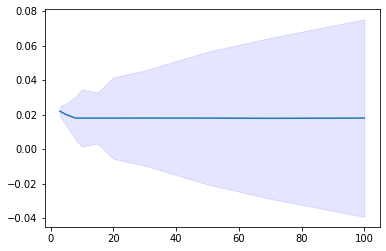

In [14]:
fig, ax = plt.subplots()
ax.plot(x, mean)
ax.fill_between(x, (mean - std), (mean + std), color='b', alpha=.1)

Il apparaît que l'accuracy se situe aux alentours de 2%, avec un écart type important si on le compare à cette accuracy.

In [15]:
cross_val = cross_validate(model,
                           X=splitted_df['blocks'],
                           y=splitted_df['ingredients'],
                           scoring=accuracy_scorer,
                           cv=10,
                          )
print(f'Strict accuracy yields a result of {np.mean(cross_val["test_score"]):.2%} +/-{np.std(cross_val["test_score"]):.2%}')
print(cross_val['test_score'])

Strict accuracy yields a result of 1.80% +/-1.66%
[0.04 0.   0.   0.04 0.02 0.02 0.   0.02 0.   0.04]


### Ajout d'une étape de text-postprocessing

On utilise la fonction `custom_accuracy` définie dans le module pimest pour calculer l'accuracy avec du text processing.
Elle prend en paramètre les mêmes attributs que le `CountVectorizer` de scikit-learn, en plus d'un attribut "tokenize" qui va tokenizer le résultat (pour prise en compte des whitespace et de la ponctuation).

In [16]:
custom_accuracy(model, 
                test['blocks'].fillna(''),
                test['ingredients'].fillna(''),
                tokenize=True,
                strip_accents='unicode',
                lowercase=True,
               )

0.14

L'accuracy est maintenant estimée à 14% (vs. 1%) sur le set de test, après entraînenemt sur le set d'entraînement.

On peut manuellement inspecter les blocks identique, en reproduisant le comportement de la fonction d'accuracy : 

In [17]:
def text_processor(text, **kwargs):
    unused_model = CountVectorizer(**kwargs)
    prepro = unused_model.build_preprocessor()
    token = unused_model.build_tokenizer()    
    return(' '.join(token(prepro(text))))

partial_processor = partial(text_processor, strip_accents='unicode', lowercase=True)

In [18]:
prediction = model.predict(test['blocks'].fillna('')).rename('predicted')
processed_prediction = prediction.apply(partial_processor)
processed_prediction.sample(3)

uid
5a7f235d-eba4-43b2-ab52-2c2b93f68a67    cette fiche technique pas de valeur contractue...
b7d7621a-fcdd-4487-9b38-e07fae698c4a    egoutter ne pas rincer faire sauter minutes av...
df1caa23-9714-4659-803b-33501d64eead    liste des ingredients sucre pate de cacao beur...
Name: predicted, dtype: object

In [19]:
processed_ground_truth = test['ingredients'].fillna('').apply(partial_processor)
processed_ground_truth.sample(3)

uid
484ac00a-a670-46a9-a9c4-5114174d9e3b    pommes de terre 59 celeris 40 amidon de mais s...
63968dc3-6e7c-4056-bd53-820c6cc925be    carottes eau sucre sel vinaigre alcool acidifi...
8dec0469-c9f5-4139-be25-efa258959444    sucre sirop de glucose graisse de palme humect...
Name: ingredients, dtype: object

In [20]:
corrects = test.join(prediction).loc[processed_prediction == processed_ground_truth , ['ingredients', 'predicted']]
corrects

,ingredients,predicted
uid,,
345591f4-d887-4ddc-bb40-21337fa9269d,"Gésier de dinde émincé 50%, graisse de canard ...","Gésier de dinde émincé 50%, graisse de canard..."
13980d31-9002-457d-8d49-b451f08f473c,"Edulcorants sorbitol, isomalt, sirop de maltit...","Edulcorants sorbitol, isomalt, sirop de maltit..."
c3b6b4df-e586-4f10-8e58-15fbf0816acb,"mini poivrons jaunes, eau, sucre, sel, affermi...","mini poivrons jaunes, eau, sucre, sel, affermi..."
0481d91b-9653-42e7-b525-9dc9b87b06f2,"Farine de BLE, huile de colza non hydrogénée, ...","Farine de BLE, huile de colza non hydrogénée, ..."
484ac00a-a670-46a9-a9c4-5114174d9e3b,"Pommes de terre 59,5 % - Céleris 40 % - Amidon...","Pommes de terre 59,5 % - Céleris 40 % - Amidon..."
49b11281-34ea-44b0-a11c-4ae21d4c58e3,,
d59d96cb-0230-4090-8220-78ce8496fd91,Amidon de maïs* - Lait écrémé* - Sel - Fécule ...,Amidon de maïs* - Lait écrémé* - Sel - Fécule ...
b8cbe6f9-71d4-4e51-a169-1c163d49a561,"Farine de FROMENT, poudre de LACTOSERUM, sucre...","Farine de FROMENT, poudre de LACTOSERUM, sucre..."
a0492df6-9c76-4303-8813-65ec5ccbfa70,"Eau, maltodextrine, sel, arômes, sucre, arôme ...","Eau, maltodextrine, sel, arômes, sucre, arôme ..."


In [21]:
with pd.option_context("max_colwidth", 100000):
    tex_str = (
    corrects.replace(r'^\s*$', np.nan, regex=True)
            .to_latex(index=False,
                      index_names=False,
                      column_format='p{7cm}p{7cm}',
                      na_rep='<rien>',
                      longtable=False,
                      header=["Liste d'ingrédients cible", "Liste d'ingrédients prédite"],
                      # label='tbl:GT_postprocessed_corrects',
                      # caption="Prédictions identifiées comme correctes après postprocessing",
                  )
             .replace(r'\textbackslash n', r' \newline ')
             .replace(r'\\', r'\\ \hline')
    )
    
# with open(Path('..') / 'tbls' / 'GT_postprocessed_corrects.tex', 'w') as file:
#     file.write(tex_str)

### Cross-validation de l'approche avec text processing

On fait tourner une cross-validation sur l'ensemble du dataset. 
On définit d'abord la fonction qui va permettre de calculer le score avec l'ensemble des fonctionnalités de text processing : 
- retrait des accents
- remplacement des whitespaces par des espaces simples
- retrait de la ponctution
- mise en minuscule

In [22]:
processed_accuracy = partial(custom_accuracy,
                             tokenize=True,
                             strip_accents='unicode',
                             lowercase=True,
                            )
cross_val = cross_validate(model,
                           X=splitted_df['blocks'].fillna(''),
                           y=splitted_df['ingredients'].fillna(''),
                           scoring=processed_accuracy,
                          )
print(f'Processed accuracy yields a result of {np.mean(cross_val["test_score"]):.2%} +/-{np.std(cross_val["test_score"]):.2%}')
print(cross_val['test_score'])

Processed accuracy yields a result of 16.40% +/-2.15%
[0.19 0.15 0.17 0.13 0.18]


In [23]:
x = [3, 5, 8, 10, 15, 20, 30, 50, 70, 100]
mean = np.array([])
std = np.array([])
for n_cv in x:
    cross_val = cross_validate(model,
                               X=splitted_df['blocks'].fillna(''),
                               y=splitted_df['ingredients'].fillna(''),
                               scoring=processed_accuracy, 
                               cv=n_cv,
                              )
    mean = np.append(mean, [np.mean(cross_val['test_score'])], axis=0)
    std = np.append(std, [np.std(cross_val['test_score'])], axis=0)

print('mean:', mean, '\nstandard dev:', std)

mean: [0.16994926 0.164      0.16199437 0.162      0.15787285 0.158
 0.15772059 0.158      0.15739796 0.158     ] 
standard dev: [0.0193811  0.02154066 0.04252373 0.034      0.06292686 0.07639372
 0.09256313 0.12343419 0.13740531 0.16320539]


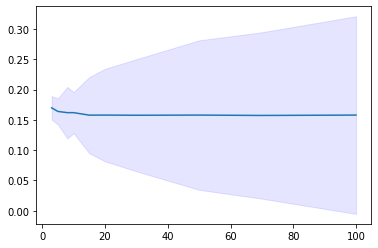

In [24]:
fig, ax = plt.subplots()
ax.plot(x, mean)
ax.fill_between(x, (mean - std), (mean + std), color='b', alpha=.1)

In [25]:
cross_val = cross_validate(model,
                           X=splitted_df['blocks'].fillna(''),
                           y=splitted_df['ingredients'].fillna(''),
                           scoring=processed_accuracy,
                           cv=10,
                          )
print(f'Processed accuracy yields a result of {np.mean(cross_val["test_score"]):.2%} +/-{np.std(cross_val["test_score"]):.2%}')
print(cross_val['test_score'])

Processed accuracy yields a result of 16.20% +/-3.40%
[0.2  0.18 0.18 0.12 0.12 0.22 0.14 0.12 0.16 0.18]


## Mesure de la performance : Similarité

### Mesures

On peut également mesurer la similarité plutôt qu'uniquement l'accuracy. Cela permet de valoriser les textes qui "ressemblent" aux listes d'ingrédients cibles plutôt que les compter comme des erreurs.

In [26]:
similarity_kinds = ['levenshtein',
                    'damerau-levenshtein', 
                    'jaro',
                    'jaro-winkler',
                   ]

sim_dict = dict()

for similarity in similarity_kinds:
    sim = text_sim_score(model, 
                         test['blocks'].fillna(''),
                         test['ingredients'].fillna(''),
                         similarity=similarity,
                        )
    sim_dict[similarity] = f'{sim:.2%}'
    print(f'Similarity with {similarity} similarity is {sim:.2%}')

Similarity with levenshtein similarity is 47.88%
Similarity with damerau-levenshtein similarity is 47.88%
Similarity with jaro similarity is 63.30%
Similarity with jaro-winkler similarity is 65.28%


Les similarités de Levenshtein et Damerau-Levenshtein donnent des résultats identiques, à presque 50% de similarité moyenne. Celles basées sur Jaro tournent aux alentours de 65%, comme on s'y attendait dans la mesure où elle est très "indulgente" sur les textes longs.

Si on effectue des cross validations sur chacune de ces distances sur le dataset complet, on obtient :

In [27]:
similarities = {similarity: partial(text_sim_score, similarity=similarity) for similarity in similarity_kinds}

cross_vals = dict()

for similarity in similarity_kinds:
    cross_vals[similarity] = cross_validate(model, 
                                            splitted_df['blocks'].fillna(''),
                                            splitted_df['ingredients'].fillna(''),
                                            scoring=similarities[similarity],
                                            cv=10,
                                            )
for similarity in similarity_kinds:
    print(f'Model evaluated with {similarity} similarity a result of '
          f'{np.mean(cross_vals[similarity]["test_score"]):.2%} '
          f'+/-{np.std(cross_vals[similarity]["test_score"]):.2%}')

Model evaluated with levenshtein similarity a result of 48.96% +/-3.95%
Model evaluated with damerau-levenshtein similarity a result of 48.97% +/-3.94%
Model evaluated with jaro similarity a result of 62.34% +/-3.39%
Model evaluated with jaro-winkler similarity a result of 63.81% +/-3.39%


On transforme en tableau latex pour insertion dans le rapport.

In [28]:
result_strings = dict()

for similarity in similarity_kinds:
    result_strings[similarity] = {'train/test set': sim_dict[similarity], 
                                  'cross validation': f'{np.mean(cross_vals[similarity]["test_score"]):.2%} '
                                                      f'+/-{np.std(cross_vals[similarity]["test_score"]):.2%}'}
result_df = pd.DataFrame(result_strings).T
print(result_strings)
labs = {'levenshtein': 'Levenshtein',
        'damerau-levenshtein': 'Damerau-Levenshtein',
        'jaro': 'Jaro',
        'jaro-winkler': 'Jaro-Winkler',
       }
# (result_df.rename(labs)
#           .to_latex(Path('..') / 'tbls' / 'similarities_result.tex',
#                    column_format='lcc',
#                    bold_rows=True,
#                   )
# )

{'levenshtein': {'train/test set': '47.88%', 'cross validation': '48.96% +/-3.95%'}, 'damerau-levenshtein': {'train/test set': '47.88%', 'cross validation': '48.97% +/-3.94%'}, 'jaro': {'train/test set': '63.30%', 'cross validation': '62.34% +/-3.39%'}, 'jaro-winkler': {'train/test set': '65.28%', 'cross validation': '63.81% +/-3.39%'}}


### Illustration

On illustre les différents niveaux de similarité sur le set de test après entrainement sur le set d'entrainement.

In [29]:
# building the dataframe
y_pred = model.predict(test['blocks']).rename('predicted')
comp_df = pd.concat([test['ingredients'].fillna(''), y_pred], axis=1)
processed_df = comp_df.applymap(build_text_processor())

# computing similarities and ranks
sim_funcs = {sim: partial(text_similarity, similarity=sim) for sim in similarity_kinds}
for sim in similarity_kinds:
    processed_df[sim] = processed_df.apply(lambda x: sim_funcs[sim](x['ingredients'], x['predicted']), axis=1)
    processed_df[sim + '_rank'] = processed_df[sim].rank(axis=0, method='first', ascending=False)

In [31]:
(processed_df.join(comp_df, lsuffix='_')
             .sort_values(['levenshtein'], ascending=False)
             .loc[(processed_df['ingredients'] != '') & (processed_df['predicted'] != '')]
).sample(4)

,ingredients_,predicted_,levenshtein,levenshtein_rank,damerau-levenshtein,damerau-levenshtein_rank,jaro,jaro_rank,jaro-winkler,jaro-winkler_rank,ingredients,predicted
uid,,,,,,,,,,,,
c2ef743e-f3f2-4e8a-aab0-1e6cbeb71666,farine de ble 20 huile de colza oeufs entiers ...,liste ingredients les ingredients mis en œuvre...,0.736196,35.0,0.736196,35.0,0.748640,40.0,0.748640,43.0,Farine de BLÉ 20% - Huile de colza - OEUFS ent...,LISTE D'INGREDIENTS\nLes ingrédients mis en œu...
1868226c-812c-438d-bba4-6b046537d0cd,pate tartiner aux noisettes et au cacao 81 suc...,ingredients pate tartiner aux noisettes et au ...,0.254144,59.0,0.254144,59.0,0.606535,55.0,0.606535,58.0,"pâte à tartiner aux noisettes et au cacao 81,5...",Ingrédients : pâte à tartiner aux noisettes et...
a57c1561-b88e-4694-8bd8-55623f2afa17,lentilles blondes,cette fiche technique pas de valeur contractue...,0.022546,88.0,0.022546,88.0,0.389566,87.0,0.389566,87.0,Lentilles blondes,Cette fiche technique n’a pas de valeur contra...
04235024-80f3-46c2-bad0-aae0d5fab024,persil,cereales contenant du gluten savoir ble seigle...,0.045455,85.0,0.045455,85.0,0.507576,73.0,0.507576,73.0,Persil,"Céréales contenant du gluten (à savoir blé, se..."


In [32]:
(
processed_df.sort_values('levenshtein_rank')
            .loc[(processed_df['ingredients'] != '') &
                 (processed_df['predicted'] != '') &
                (processed_df['predicted'].apply(len) <=300)]
            .join(comp_df, lsuffix='_')
            .iloc[np.r_[0:3, 47:50, -3:0]]
            )

,ingredients_,predicted_,levenshtein,levenshtein_rank,damerau-levenshtein,damerau-levenshtein_rank,jaro,jaro_rank,jaro-winkler,jaro-winkler_rank,ingredients,predicted
uid,,,,,,,,,,,,
345591f4-d887-4ddc-bb40-21337fa9269d,gesier de dinde emince 50 graisse de canard 47...,gesier de dinde emince 50 graisse de canard 47...,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,"Gésier de dinde émincé 50%, graisse de canard ...","Gésier de dinde émincé 50%, graisse de canard..."
c3b6b4df-e586-4f10-8e58-15fbf0816acb,mini poivrons jaunes eau sucre sel affermissan...,mini poivrons jaunes eau sucre sel affermissan...,1.000000,3.0,1.000000,3.0,1.000000,3.0,1.000000,4.0,"mini poivrons jaunes, eau, sucre, sel, affermi...","mini poivrons jaunes, eau, sucre, sel, affermi..."
0481d91b-9653-42e7-b525-9dc9b87b06f2,farine de ble huile de colza non hydrogenee oe...,farine de ble huile de colza non hydrogenee oe...,1.000000,4.0,1.000000,4.0,1.000000,4.0,1.000000,5.0,"Farine de BLE, huile de colza non hydrogénée, ...","Farine de BLE, huile de colza non hydrogénée, ..."
a2418174-e16a-41e0-ac14-c87208fb3529,salicornes de culture eau sel acide citrique,se consomment en legumes accompagnement avec t...,0.209677,66.0,0.209677,66.0,0.511730,72.0,0.560557,65.0,"Salicornes de culture, eau, sel, acide citrique",Se consomment en légumes d'accompagnement avec...
d8b0687e-5e25-4ff9-9384-087f993218bc,eau jus de fruit de la passion sucre epaississ...,cereales contenant du gluten crustaces et prod...,0.200692,67.0,0.200692,67.0,0.553928,64.0,0.553928,66.0,Eau ; jus de fruit de la passion ; sucre ; épa...,Céréales contenant du gluten (2) \nCrustacés e...
536361db-1bbb-4e64-ae53-d970eeac7db2,sucre amidon de mais arome vanille,ajouter le produit la preparation avec les aut...,0.200000,68.0,0.200000,68.0,0.491130,75.0,0.491130,75.0,"Sucre, amidon de maïs, arôme vanille",ajouter le produit à la préparation avec les a...
3634fb1e-ee79-41d1-8aaa-084c1fae5bd5,poire 99 antioxydant acide ascorbique,ce produit est une puree de fruits obtenue par...,0.096667,78.0,0.096667,78.0,0.437327,83.0,0.437327,83.0,"Poire 99,9%, antioxydant: acide ascorbique.",Ce produit est une purée de fruits obtenue à p...
8d833da0-610f-4045-9877-adf8ad9ea56c,100 haricots blancs bio,les legumes secs sont mis en avant par tous le...,0.066176,82.0,0.066176,82.0,0.354719,90.0,0.354719,90.0,100% haricots blancs bio,Les légumes secs sont mis en avant par tous le...
04235024-80f3-46c2-bad0-aae0d5fab024,persil,cereales contenant du gluten savoir ble seigle...,0.045455,85.0,0.045455,85.0,0.507576,73.0,0.507576,73.0,Persil,"Céréales contenant du gluten (à savoir blé, se..."


In [33]:
# outputing to latex
with pd.option_context("max_colwidth", 100000):
    tex_str = (processed_df.sort_values('levenshtein_rank')
                           .loc[(processed_df['ingredients'] != '') &
                                (processed_df['predicted'] != '') &
                                (processed_df['predicted'].apply(len) <=300)]
                           .join(comp_df, lsuffix='_')
                           .iloc[np.r_[0:3, 47:50, -3:0]]
                           .to_latex(columns=['ingredients', 'predicted', 'levenshtein', # 'levenshtein_rank',
                                              'damerau-levenshtein', 'jaro', 
                                              'jaro-winkler'],
                                     index=False,
                                     index_names=False,
                                     column_format='p{5cm}p{5cm}cccc',
                                     formatters={'levenshtein': lambda x: f'{x:.2%}', 
#                                                  'levenshtein_rank': lambda x: f'{x:1.0f}',
                                                 'damerau-levenshtein': lambda x: f'{x:.2%}', 
                                                 #'damerau-levenshtein_rank': lambda x: f'{x:1.0f}',
                                                 'jaro': lambda x: f'{x:.2%}',
                                                 #'jaro_rank': lambda x: f'{x:1.0f}',
                                                 'jaro-winkler': lambda x: f'{x:.2%}',
                                                 #'jaro-winkler_rank': lambda x: f'{x:1.0f}',
                                                },
                                     header=["Listes d'ingrédients cibles", "Listes d'ingrédients prédites",
                                             'Lev', 'Dam-Lev', 'Jaro', 'Jaro-Win'],
                                     na_rep = '<rien>',
                                    )
    ).replace(r'\textbackslash n', r' \newline ').replace(r'\\', r'\\ \hline')
    
# with open(Path('..') / 'tbls' / 'similarity_illustration.tex' , 'w') as file:
#     file.write(tex_str)


## Similarité vs. longueur des listes d'ingrédients

On compare le score de similarité obtenu par rapport à la longueur des listes d'ingrédients cibles.

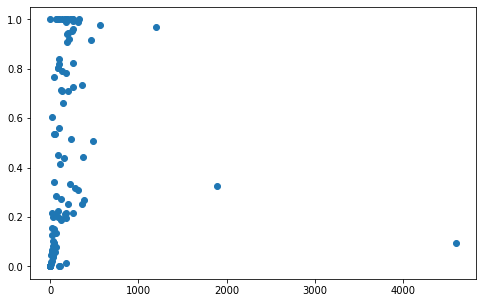

In [34]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(y=processed_df['levenshtein'], x=processed_df['ingredients'].apply(len))

On a des outliers qui vont avoir trop d'importance sur les résultats. On va les filtrer.

In [35]:
filtered = processed_df.loc[processed_df['ingredients'].apply(len) <= 350]

In [36]:
print('r2 : ', linregress(x=filtered['ingredients'].apply(len), y=filtered['levenshtein']).rvalue ** 2)
linregress(x=filtered['ingredients'].apply(len), y=filtered['levenshtein'])

r2 :  0.3249291855359084


LinregressResult(slope=0.002425601437356884, intercept=0.19097219058918768, rvalue=0.5700256007723762, pvalue=4.512591966582692e-09, stderr=0.0003726991570207304)

(-0.1, 1.1)

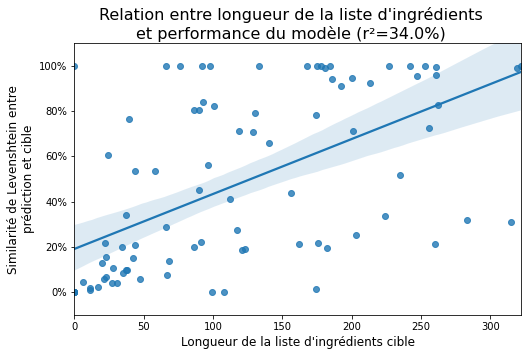

In [37]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.regplot(x=filtered['ingredients'].apply(len), y=filtered['levenshtein'], ax=ax)
ax.set_xlabel("Longueur de la liste d'ingrédients cible", fontsize=12)
ax.set_ylabel("Similarité de Levenshtein entre\nprédiction et cible", fontsize=12)
fig.suptitle("Relation entre longueur de la liste d'ingrédients\net performance du modèle (r²=34.0%)", fontsize=16)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.))
ax.set_ylim(-0.1, 1.1)
# fig.savefig(Path('..') / 'img' / 'perf_vs_length.png', bbox_inches='tight')